<a href="https://colab.research.google.com/github/AlfZuck1/MLP_Cifar100/blob/main/notebookMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'itba-cifar-100-2024-q-1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77584%2F8490010%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240628%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240628T005657Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1ea3a07052edaf7f5bb5fe3345fb8faf20e81cea2fb2b0a3571c5b5f1e7e4b88f7d7b8203e9ca7b74667398a845bc2ee967286435e1417449ff39baadc5aab168dcb76e74b331d82c5fb57a716950dab0a5da79a99a4e07e6db48d62e826ab86b095ec58680409aa9b8e75b92b400c6810aaccba5e6be89f25c413b8ffb86ef18d26ebd8a0e3a51f25dd771abfb1948693c4ac8a4f36462a5894e3ac647c0f72a982a81ec443d7ad4011a46f03fa033c724a54f4ec6c24cbe4d9f0fe3ac96694c916aa5f52ca52b7069354ef1c168ecf819a4e939ff0f0e73ace0baf35811c389b9f1de5aceecacd7a08d50e1915655123e82ba7310e7d62fcb2a64c50fc8924'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 168426762 bytes downloaded
Downloaded and uncompressed: itba-cifar-100-2024-q-1
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy
/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck


In [3]:
x_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")/255.
x_test = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy")/255.
y_train_coarse = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy")
y_train_fine = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy")

In [4]:
import pickle
with open("/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [5]:
from matplotlib import pyplot as plt
%load_ext tensorboard

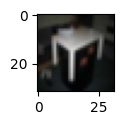

In [6]:
plt.figure(figsize=(1,1))
plt.imshow(x_train[25])

In [7]:
y_train_fine[25]

84

In [8]:
labels_fine[84]

'table'

In [9]:
# Me fijo para una categoría de grano grueso, cuáles son las categorías de grano fino
coarse = 6
print(f"Grano grueso: {labels_coarse[coarse]}")
for fine in np.unique(y_train_fine[y_train_coarse == coarse]):
    print(f"Grano fino: {labels_fine[fine]}")

Grano grueso: household_furniture
Grano fino: bed
Grano fino: chair
Grano fino: couch
Grano fino: table
Grano fino: wardrobe


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam, AdamW, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

In [11]:
x_train.shape

(50000, 32, 32, 3)

In [12]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Dense(1536,activation = "leaky_relu",use_bias=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation= "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 batch_normalization (Batch  (None, 3072)              12288     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1536)              4720128   
                                                                 
 batch_normalization_1 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               1

In [14]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 2,
    verbose = 1,
    min_lr = 1e-7,
)


In [15]:
mc = ModelCheckpoint(
    "best.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [16]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 8,
    verbose = 1,
    restore_best_weights = True,
)

In [17]:
data_val = ImageDataGenerator(validation_split = 0.2)

data_train = ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2)

train_data = data_train.flow(x_train, y_train_fine, batch_size=64, subset='training')
val_data = data_val.flow(x_train, y_train_fine, batch_size=64, subset='validation')


In [18]:
tb = TensorBoard(
    log_dir="logs",
)

In [19]:
history = model.fit(
    train_data,
    epochs = 200,
    validation_data = val_data,
    callbacks= [rlrop, es, mc, tb]
)

Epoch 1/200
625/625 [==============================] - ETA: 0s - loss: 4.7141 - accuracy: 0.0838
Epoch 1: val_accuracy improved from -inf to 0.14060, saving model to best.weights.h5
625/625 [==============================] - 25s 33ms/step - loss: 4.7141 - accuracy: 0.0838 - val_loss: 3.8668 - val_accuracy: 0.1406 - lr: 0.0010
Epoch 2/200
624/625 [============================>.] - ETA: 0s - loss: 4.1805 - accuracy: 0.1143
Epoch 2: val_accuracy improved from 0.14060 to 0.16760, saving model to best.weights.h5
625/625 [==============================] - 21s 33ms/step - loss: 4.1802 - accuracy: 0.1142 - val_loss: 3.6944 - val_accuracy: 0.1676 - lr: 0.0010
Epoch 3/200
624/625 [============================>.] - ETA: 0s - loss: 3.9363 - accuracy: 0.1350
Epoch 3: val_accuracy improved from 0.16760 to 0.18670, saving model to best.weights.h5
625/625 [==============================] - 22s 35ms/step - loss: 3.9368 - accuracy: 0.1349 - val_loss: 3.5630 - val_accuracy: 0.1867 - lr: 0.0010
Epoch 4/20

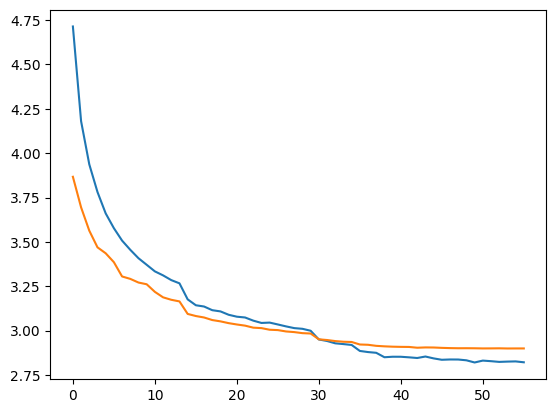

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

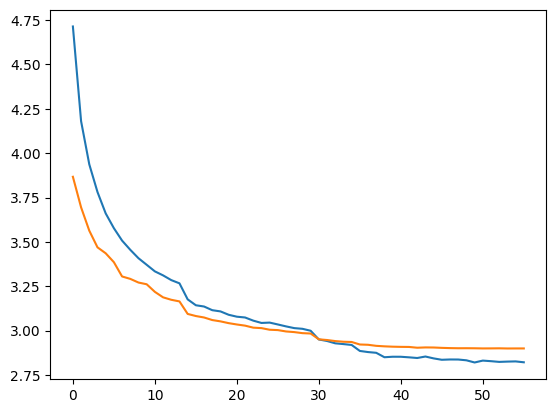

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

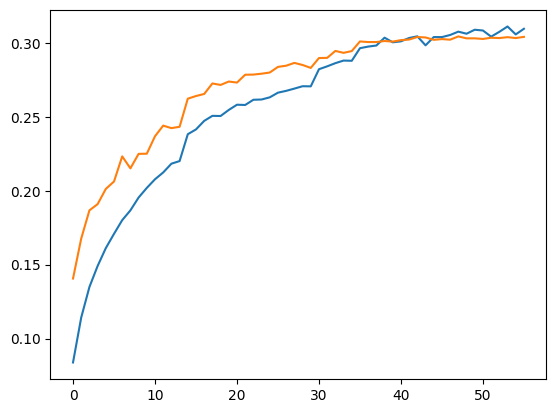

In [22]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

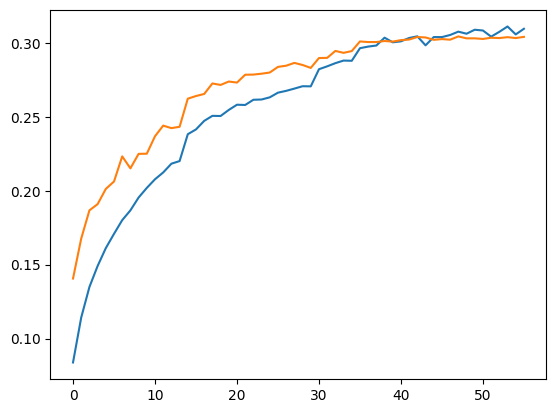

In [23]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

In [24]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [25]:
predictions = predictions.argmax(axis=1)

In [26]:
predictions

array([12, 42, 15, ..., 18, 34,  0])

In [27]:
df = pd.DataFrame(predictions, columns=["Label"])

In [28]:
df.index.name = "Id"

In [29]:
df.head()

,Label
Id,
0,12
1,42
2,15
3,40
4,71


In [30]:
df.to_csv("submission.csv")